In [6]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
data = pd.read_csv("googleplaystore.csv")

def getinstalls(x):
    out = ""
    for i in re.findall(r".*[^+]", x)[0].split(","): out+=i
    print(out)
    print()
    return out


In [7]:
class Preprocessing():
    def __init__(self, data):
        self.data = data

    def dropjunk(self):
        self.data = self.data.drop(["App", "Last Updated", "Current Ver", "Android Ver"], axis=1)

    def price(self):
        self.data["Price"] = pd.to_numeric(pd.Series(map(lambda x: x[1:],self.data["Price"])))

    def getinstalls(self):
        self.data["Installs"] = self.data["Installs"].apply(lambda a: "".join(re.findall(r".*[^+]", a)[0].split(",")))
        self.data["Installs"] = pd.to_numeric(self.data["Installs"])

    def sizefunc(self):
        self.data["Size"] = self.data["Size"].apply(lambda size: float(size[:-1])*1000 if 'M' in size else (float(size[:-1]) if 'k' in size else None))
        self.data.Size.fillna(method = 'ffill', inplace = True)

    def outlayers(self, field):
        distance = 1.5 * (np.percentile(self.data[field], 75) - np.percentile(self.data[field], 25))
        self.data.drop(self.data[self.data[field] > distance + np.percentile(self.data[field], 75)].index, inplace=True)
        self.data.drop(self.data[self.data[field] < np.percentile(self.data[field], 25) - distance].index, inplace=True)

    def pricer(self):
        self.data["Type"] = self.data["Type"].map(lambda price: 0 if price=="Free" else 1)

    def cleaner(self):
        pass

    def preprocess(self):
        self.dropjunk()
        self.getinstalls()
        self.sizefunc()
        self.price()
        self.outlayers("Size")
        self.outlayers("Price")
        self.data.Installs = np.log(self.data.Installs)
        self.outlayers("Installs")
        self.data.loc[self.data.Installs <= 4, ["Installs"]] = self.data.Installs.median()
        self.data.loc[self.data.Size > 50000, "Size"] = self.data.Size.median()
        self.data.Reviews = np.log(self.data.Reviews)
        self.outlayers("Reviews")
        self.pricer()
        return self.data

preproc = Preprocessing(data)
data = preproc.preprocess()
data = data.dropna()

data


/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
234,BUSINESS,4.7,9.345046,6800.0,11.512925,1,4.99,Everyone,Business
235,BUSINESS,4.8,9.239414,39000.0,11.512925,1,4.99,Everyone,Business
290,BUSINESS,4.7,9.345046,6800.0,11.512925,1,4.99,Everyone,Business
291,BUSINESS,4.8,9.239414,39000.0,11.512925,1,4.99,Everyone,Business
427,COMMUNICATION,4.0,9.811756,2300.0,11.512925,1,3.99,Everyone,Communication
...,...,...,...,...,...,...,...,...,...
10689,PERSONALIZATION,5.0,1.609438,861.0,4.605170,1,0.99,Everyone,Personalization
10696,GAME,5.0,0.693147,16000.0,11.512925,1,0.99,Everyone,Arcade
10759,HEALTH_AND_FITNESS,4.4,3.555348,2400.0,6.907755,1,7.99,Everyone,Health & Fitness
10781,GAME,3.8,5.529429,11000.0,9.210340,1,16.99,Teen,Action


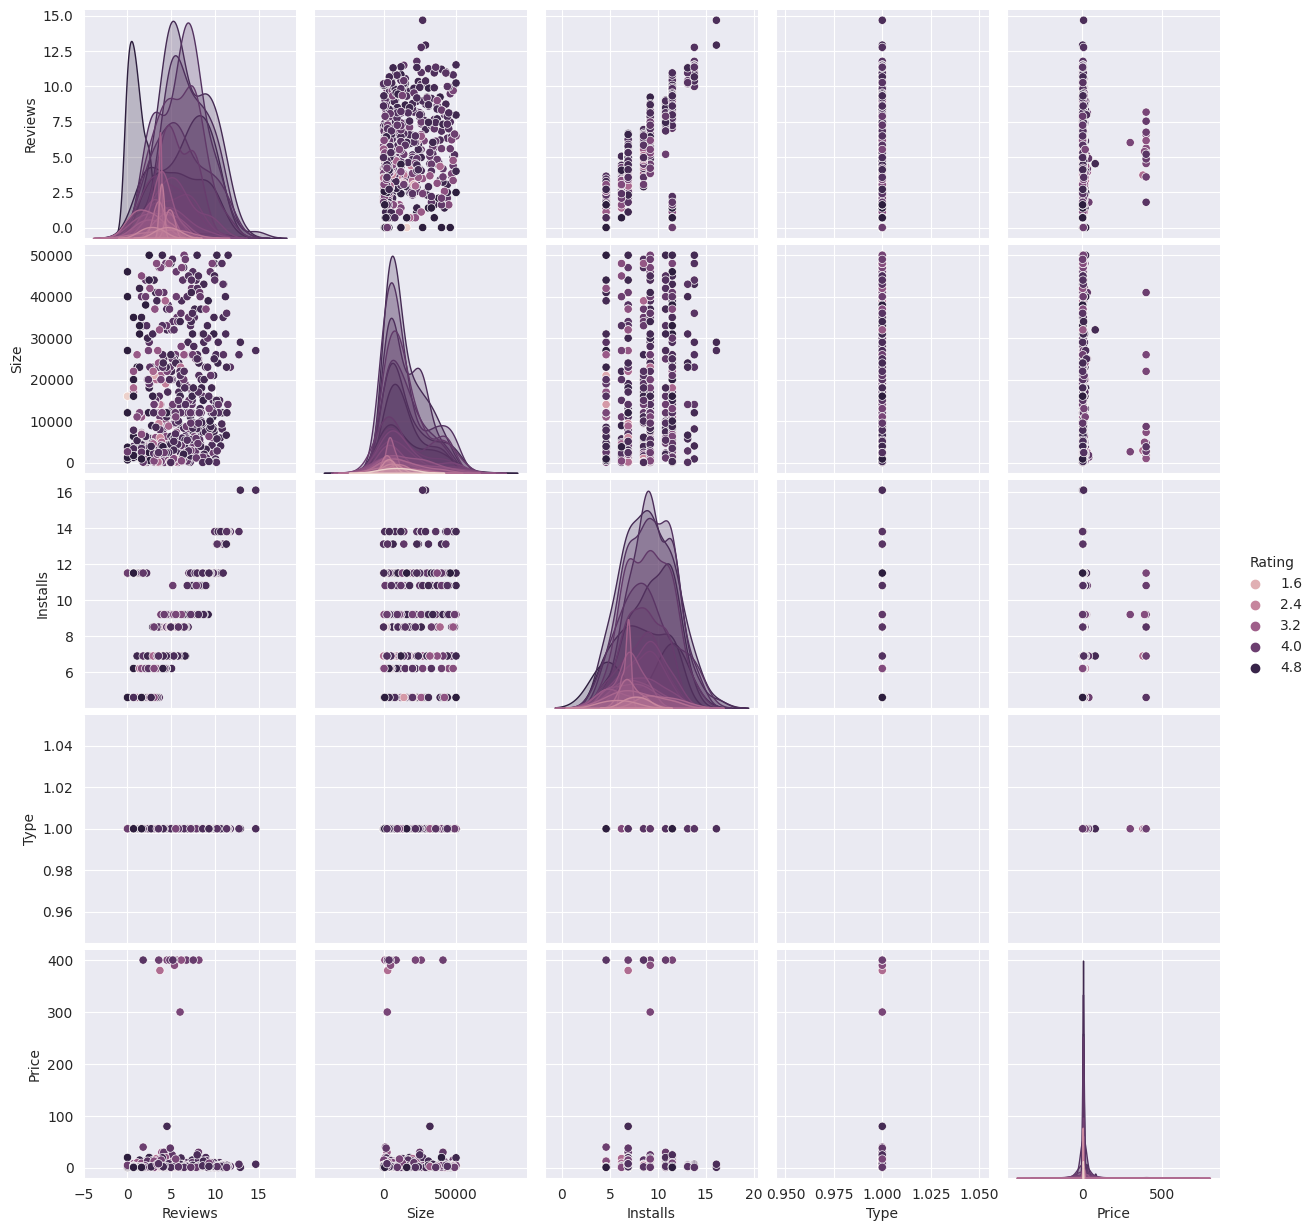

In [8]:
sns.pairplot(data, hue="Rating")

In [9]:
sns.heatmap(data.corr() [["Rating"]].sort_values(by="Rating", ascending=False), cmap="rainbow",vmin=-1, vmax=1, annot=True)

ValueError: could not convert string to float: 'BUSINESS'

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

lbe = LabelEncoder()
data.loc[:, "Category"] = lbe.fit_transform(data.loc[:, "Category"])
data.loc[:, "Content Rating"] = lbe.fit_transform(data.loc[:, "Content Rating"])
data.loc[:, "Genres"] = lbe.fit_transform(data.loc[:, "Genres"])

data["Genres"].head(100)

234     15
235     15
290     15
291     15
427     23
        ..
2289    39
2290    39
2291    39
2292    39
2293    39
Name: Genres, Length: 100, dtype: object

In [11]:
data.Category.value_counts()

Category
8     147
15     84
11     67
18     64
24     63
4      22
23     21
13     18
19     18
20     18
9      13
12     12
3      11
2       8
25      7
27      7
14      5
6       4
26      4
5       4
0       3
10      2
7       2
16      2
21      2
22      2
17      2
1       1
Name: count, dtype: int64

In [12]:
data.Category = data.Category.astype("category")

/tmp/ipykernel_37558/520251225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Category = data.Category.astype("category")


In [13]:
data.Type = data.Type.astype("category")

/tmp/ipykernel_37558/4269236192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Type = data.Type.astype("category")


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 613 entries, 234 to 10784
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Category        613 non-null    category
 1   Rating          613 non-null    float64 
 2   Reviews         613 non-null    float64 
 3   Size            613 non-null    float64 
 4   Installs        613 non-null    float64 
 5   Type            613 non-null    category
 6   Price           613 non-null    float64 
 7   Content Rating  613 non-null    object  
 8   Genres          613 non-null    object  
dtypes: category(2), float64(5), object(2)
memory usage: 40.9+ KB


array([[<Axes: title={'center': 'Rating'}>,
        <Axes: title={'center': 'Reviews'}>],
       [<Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'Installs'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >]], dtype=object)

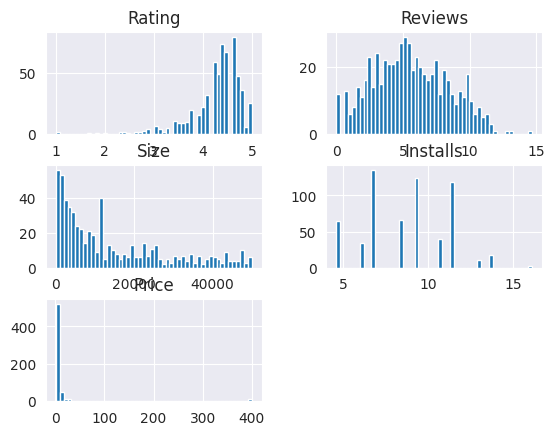

In [15]:
data.hist(bins=50)


<Axes: >

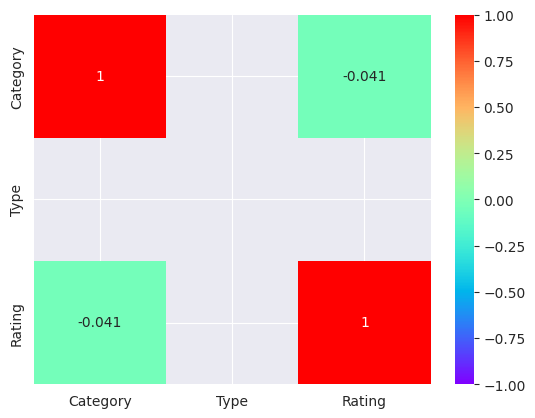

In [16]:
categ = data.loc[:,["Category", "Type", "Rating"]]
sns.heatmap(categ.corr(method="spearman", numeric_only=False), cmap="rainbow", vmin=-1, vmax=1, annot=True)


In [17]:
y = pd.DataFrame(data.Rating)
x = data.drop(["Rating"], axis=1)
x.head()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres
234,3,9.345046,6800.0,11.512925,1,4.99,0,15
235,3,9.239414,39000.0,11.512925,1,4.99,0,15
290,3,9.345046,6800.0,11.512925,1,4.99,0,15
291,3,9.239414,39000.0,11.512925,1,4.99,0,15
427,4,9.811756,2300.0,11.512925,1,3.99,0,23


In [18]:
sscaler = StandardScaler()
rscaler = RobustScaler()



x = pd.DataFrame(sscaler.fit_transform(x))
y = pd.DataFrame(sscaler.fit_transform(y))
x

,0,1,2,3,4,5,6,7
0,-1.666604,1.326252,-0.567270,1.128095,0.0,-0.155420,-0.356547,-1.263590
1,-1.666604,1.288887,1.696485,1.128095,0.0,-0.155420,-0.356547,-1.263590
2,-1.666604,1.326252,-0.567270,1.128095,0.0,-0.155420,-0.356547,-1.263590
3,-1.666604,1.288887,1.696485,1.128095,0.0,-0.155420,-0.356547,-1.263590
4,-1.511436,1.491340,-0.883633,1.128095,0.0,-0.172031,-0.356547,-0.803830
...,...,...,...,...,...,...,...,...
608,0.660921,-1.410035,-0.984799,-1.692697,0.0,-0.221866,-0.356547,0.345570
609,-0.425257,-1.734151,0.079518,1.128095,0.0,-0.221866,-0.356547,-1.838291
610,-0.270089,-0.721716,-0.876603,-0.752433,0.0,-0.105584,-0.356547,-0.056720
611,-0.425257,-0.023432,-0.271997,0.187831,0.0,0.043921,3.500452,-2.125641


array([[<Axes: title={'center': 'Rating'}>,
        <Axes: title={'center': 'Reviews'}>],
       [<Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'Installs'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >]], dtype=object)

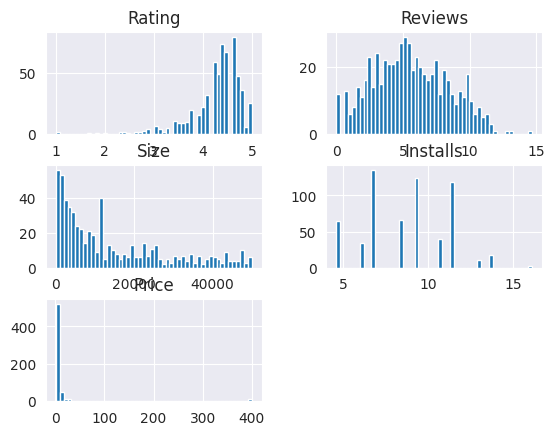

In [19]:
data.hist(bins=50)

In [20]:

from sklearn.model_selection import train_test_split

y.head()

,0
0,0.795377
1,0.977645
2,0.795377
3,0.977645
4,-0.480497


In [21]:
x.head()

,0,1,2,3,4,5,6,7
0,-1.666604,1.326252,-0.567270,1.128095,0.0,-0.155420,-0.356547,-1.26359
1,-1.666604,1.288887,1.696485,1.128095,0.0,-0.155420,-0.356547,-1.26359
2,-1.666604,1.326252,-0.567270,1.128095,0.0,-0.155420,-0.356547,-1.26359
3,-1.666604,1.288887,1.696485,1.128095,0.0,-0.155420,-0.356547,-1.26359
4,-1.511436,1.491340,-0.883633,1.128095,0.0,-0.172031,-0.356547,-0.80383


In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
y_train.head()

,0
369,0.066306
344,0.430842
118,-0.298229
79,1.342181
23,1.159913


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
dectree = BaggingRegressor()
linreg = LinearRegression()
model = dectree.fit(x_train, y_train)
predict = dectree.predict(x_test)
predict

/home/mischa/PycharmProjects/GooglePlay/venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


array([-0.06128123,  0.5766561 ,  0.24857404, -0.35290973,  0.77715069,
       -0.48049719, -0.35290973,  0.1027598 , -1.4282898 , -0.09773479,
       -1.00907384,  0.21212048, -0.02482767, -0.38936329,  0.30325439,
       -1.51942371, -1.64701117, -0.22532226, -0.49872397, -0.20709548,
       -0.00660089, -0.68099178, -0.40759007,  0.50374898,  0.23034726,
       -0.31645617, -1.50119692, -0.49872397,  0.61310966,  0.85005781,
        0.2850276 ,  0.61310966, -0.24354904, -0.29822938,  0.17566692,
       -1.50119692,  0.1027598 ,  0.48552219, -2.52189666,  0.21212048,
        0.39438829, -0.55340432,  0.50374898,  0.32148117,  0.39438829,
        0.32148117, -0.38936329,  0.32148117, -0.24354904, -0.29822938,
       -0.2800026 , -0.93616672, -1.70169151,  0.24857404, -0.82680603,
        0.64956322, -0.15241514,  0.30325439,  0.63133644, -0.26177582,
        0.01162589, -0.24354904, -0.49872397,  0.32148117, -0.51695076,
       -0.04305445,  0.50374898,  0.30325439, -0.06128123, -0.40

In [34]:
y_test

,0
370,0.795377
101,0.613110
131,0.248574
393,-0.298229
609,1.342181
...,...
354,-0.115962
83,-0.115962
90,0.430842
595,0.613110


In [35]:

dectree.score(x_test, y_test)

-0.09432516402015789

In [36]:
from sklearn.metrics import r2_score
r2_score(y_test, predict)

-0.09432516402015789